In [1]:
import numpy as np
import scipy.sparse as sps
import porepy as pp

### Aim of notebook
In this notebook, I will first try to rotate the entire setup by 90 degress.

## Define Grid 

In [2]:
Nx = Ny = 10
g = pp.CartGrid([Nx,Ny], [1,1])
g.compute_geometry()

## Define permeability matrix

In [16]:
Omega_1 = g.cell_centers[0, :] < 0.5

# Let Omega_1 be region with y < 0.5
#Omega_1 = g.cell_centers[1, :] < 0.5

#Omega_1[g.cell_centers[0, :] < 0.1] = False
#Omega_1[np.abs(g.cell_centers[0, :] - 0.7) < 0.1] = True

kxx, kyy, kxy = 1e2*np.ones(g.num_cells), np.ones(g.num_cells), 8*np.ones(g.num_cells)
kxx[Omega_1] = np.ones(np.sum(Omega_1))
kyy[Omega_1] = 1e2*np.ones(np.sum(Omega_1))
#perm = pp.SecondOrderTensor(kxx=kxx, kyy=kyy, kxy=kxy)                              
f = g.cell_volumes

#### Define Rotation matrix
This enables us to rotate the permeability matrix about the coordinate axes

In [17]:
def rot_mat(theta):
    return np.array([[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 0]])

rot90CW = rot_mat(- np.pi / 4)

In [18]:
perm = pp.SecondOrderTensor(kxx=kxx, kyy=kyy, kxy=kxy)
# Rotate permeability matrix
#perm.rotate(rot90CW)

## Define boundary conditions 


In [29]:
b_faces = g.tags['domain_boundary_faces'].nonzero()[0]

labels = np.array(['dir']*b_faces.size)
labels[g.face_centers[1, b_faces] == 1.] = 'neu'

# Do neumann on x=1 instead
#labels[g.face_centers[0, b_faces] == 1.] = 'neu'

#BC1:1 Try to add more Neumann!
labels[g.face_centers[0, b_faces] == 1.] = 'neu'


bc = pp.BoundaryCondition(g, b_faces, labels)

bc_val = np.zeros(g.num_faces)
bottom = b_faces[g.face_centers[1, b_faces] == 0.]
bc_val[bottom] = np.ones(bottom.size)

#BC1:2 Set Neumann values


# Then set the appropriate value of the bc
#left = b_faces[g.face_centers[0, b_faces] == 0.]
#bc_val[left] = np.ones(left.size)

In [30]:
specified_parameters = {"second_order_tensor": perm, "source": f, "bc": bc, "bc_values": bc_val}
data = pp.initialize_default_data(g, {}, "flow", specified_parameters)

## Solve the problem 

In [31]:
solver = pp.Tpfa("flow")
solver.discretize(g, data)
A, b = solver.assemble_matrix_rhs(g, data)
p = sps.linalg.spsolve(A, b)

In [32]:
#p[p<0]=0

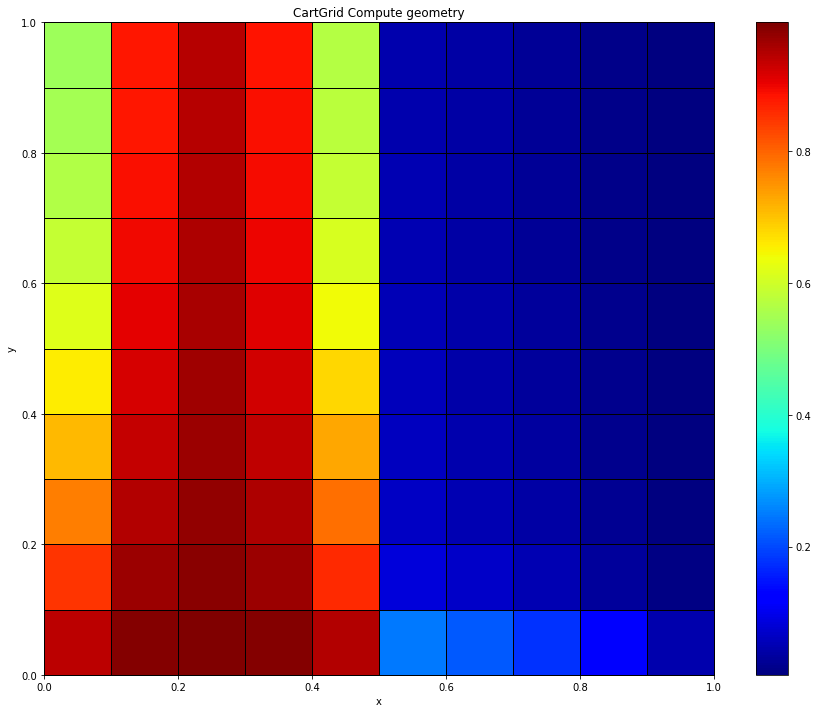

In [33]:
#pp.plot_grid(g, p, figsize=(15, 12), vmin=0., vmax=1.)
pp.plot_grid(g, p, figsize=(15, 12), plot_2d=True)